# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [2]:
#CodeRead

train_df = pd.read_csv('dataset/train.csv')
validation_df = pd.read_csv('dataset/validation.csv') 
genome_scores_df=pd.read_csv('dataset/genome_scores.csv')
movies_df=pd.read_csv('dataset/movies.csv')








In [3]:
#CodeRead

# create movie rating dataset from train

# Feature vector for the 10000 movies, each with a 1128 dimensional vector. 
# If a movie doesn't appear in genome_scores we make it simply the 0 vector.
X=np.zeros((10000,1128)) 
movies_with_featvecs=set(genome_scores_df['movieId'])
# The average rating, for each of the movies in the training set. 
# -1 if it is not in the train set.
rating_movies = -1*np.ones(10000) 

# Each movie, is labelled +1 or -1 based on whetherr it is a comedy or not
comedy = np.zeros(10000) 

for i in range(10000):
    if i not in movies_with_featvecs:
        continue
    temp = genome_scores_df[genome_scores_df['movieId']==i]
    feat_vec= np.array(temp['relevance'])
    X[i,:]=feat_vec

for i in range(10000):
    temp = train_df[train_df['movieId']==i]
    if len(temp)==0:
        continue
    ratings_curr_movies = temp['rating']
    rating_movies[i] = np.mean(ratings_curr_movies)

for i in range(10000):
    temp = movies_df[movies_df['movieId']==i]
    if len(temp)==0:
        continue
    temp = temp['genres'].values[0]
    temp = temp.split('|')
    comedy[i] = 'Comedy' in temp
    comedy[i] = 2*comedy[i] -1


In [4]:
np.array(train_df['rating']).mean()

3.3601078084681526

# Problem 1. K-Nearest Neighbours

Run k-Nearest neighbours on the binary classification dataset below, for classifiying whether a given movie is a comedy or not. The train and test feature vectors are given by X_train, X_test and the train and test ratings are Y_train and Y_test. 

Run k-Nearest neighbours for different k values (1,2,4,8,16,32,64) and report accuracies in the next cell. 

In [11]:
#CodeWrite cell
X_train = np.array(X[:8000,])
X_test = np.array(X[8000:,])

Y_train=np.array(comedy[:8000])
Y_test=np.array(comedy[8000:])


def edistance(x,y):
    dist= x-y
    dist = np.linalg.norm(dist)
    return dist

def kneighbour(k,X_train,X_test,Y_train,Y_test):
    pred=np.zeros((2000,len(k)))
    n1,m = X_train.shape
    n2,m = X_test.shape
    
    for i in range(n2):
        distances = []
        for j in range(n1):
            distances.append((edistance(X_test[i],X_train[j]),Y_train[j]))
        distances= sorted(distances,key = lambda x: x[0]) 
        l=0
        for j in k:
            temp = []
            for p in range(j):
                temp.append(distances[p][1])
            val = 0
            for s in temp:
                val = val + s
            if val >= 0:
                pred[i][l] = 1
            else:
                pred[i][l] = -1
            l = l + 1

    for i in range(len(k)):
        l=0
        for j in range(n2):
            if pred[j][i]==Y_test[j]:
                l= l + 1
        print(l/n2)
        

kneighbour([1,2,4,8,16,32,64],X_train,X_test,Y_train,Y_test)

0.841
0.8165
0.819
0.8595
0.865
0.865
0.8595


Error rates for diffrent k's

    1       0.841
    2       0.8165
    4       0.819
    8       0.8595
    16      0.865
    32      0.865
    64      0.8595
    




# Problem 2: PCA and regression

Take the regression dataset below, and perform linear regression after doing PCA on the feature vector. 

For each K in [4,32,256,1024] take the top k components and report the mean squared error on the test set below. 

For each K you can choose the regularisation hyperparameter $\lambda$ for linear regression using a 80-20 split of the training set. 

For each K above, report the best lambda and the mean squared error for this best lambda in the cell below the next.




In [118]:
# CodeWrite

X_all = X[rating_movies>0]
Y_all = rating_movies[rating_movies>0]

X_train = np.array(X_all[:7000])
Y_train = np.array(Y_all[:7000])
X_test = np.array(X_all[7000:])
Y_test = np.array(Y_all[7000:])

n,m = X_train.shape

mux = np.zeros(m)

for i in range(n):
    mux = mux + X_train[i]

mux = mux/n

cov = np.zeros((m,m))
for i in range(n):
    a = (X_train[i]-mux)[np.newaxis].transpose()
    b = (X_train[i]-mux)[np.newaxis]
    cov = cov + np.matmul(a,b)
    
cov = cov / n
values,vectors = np.linalg.eig(cov)
dic = {}
for i in range(len(values)):
    dic[values[i]] = vectors[i]
    
l = list(dic.keys())
l = sorted(l)
l.reverse()


k = 2
kmul = np.zeros((k,1128))
for i in range(k):
    kmul[i] = dic[l[i]]

Xptrain = np.matmul(X_train,kmul.T)
Xptest = np.matmul(X_test,kmul.T)



[2.80949509e+00 1.22663121e+00 1.02933393e+00 ... 1.04635340e-03
 1.09520775e-03 9.99545528e-04]
(1128,)


In [119]:
def regression(X,Y,X_test,Y_test,reg_param=0.01):
    X_t=X[:5600,:]
    Y_t=Y[:5600]
    X_v=X[5600:,:]
    Y_v=Y[5600:]
    
    m,d=X_t.shape
    term1=X_t.T @ X_t
    const=m*reg_param/2*np.identity(d)
    part1=term1+const
    part1=np.linalg.inv(part1)
    part2=X_t.T @ Y_t
    wt=part1 @ part2
    
    Y_pred=X_v@wt
    Y_predm = Xptest@wt
    print('\t\tvalidation error:',reg_param,mean_squared_error(Y_pred,Y_v))
    print('\t\test error:',reg_param,mean_squared_error(Y_predm,Y_test))
    print('')
    return wt



for i in [4,32,256,1024]:
    kmul = np.zeros((i,1128))
    for j in range(i):
        kmul[j] = dic[l[j]]

    Xptrain = np.matmul(X_train,kmul.T)
    Xptest = np.matmul(X_test,kmul.T)
    for j in [1e-9,1e-7,1e-6,1e-5,1e-3,1e-2,1,10]:
        regression(Xptrain,Y_train,Xptest,Y_test,j)
    
    


		validation error: 1e-09 2.4612390293896618
		est error: 1e-09 2.4872164402066015

		validation error: 1e-07 2.4612376288147657
		est error: 1e-07 2.4872160819272207

		validation error: 1e-06 2.4612248970681656
		est error: 1e-06 2.487212825387662

		validation error: 1e-05 2.461097654156739
		est error: 1e-05 2.487180314062723

		validation error: 0.001 2.4479149856673645
		est error: 0.001 2.4841932019448913

		validation error: 0.01 2.3915159253199114
		est error: 0.01 2.5022209920828034

		validation error: 1 9.419163657034957
		est error: 1 8.739583213907052

		validation error: 10 11.203547022130419
		est error: 10 10.219653952101721

		validation error: 1e-09 0.7920863470133593
		est error: 1e-09 0.6876482988155614

		validation error: 1e-07 0.7920864079030343
		est error: 1e-07 0.6876484455539285

		validation error: 1e-06 0.7920869617924035
		est error: 1e-06 0.6876497799076035

		validation error: 1e-05 0.7920925349948504
		est error: 1e-05 0.687663159885083

		validation e

TextWrite cell. Report best lambda and the mean squared error on the test set, for different K here.


    | <!-- -->   | Reg-Param  |  MSE |
    |---|---|---|---|
    | 4  | 0.001   | 2.484  |
    | 32  | 1e-09 | 0.687  |
    | 256  | 1e-9  | 0.302  |
    | 1024  | 0.001  |  0.236 |

# Problem 3: Baseline methods for collaborative filtering

Run the baseline methods discussed in class for collaborative filtering. Use the old train.csv to train and the newly provided validation.csv to report your mean squared errors. 


In [67]:
#CodeWrite

def baseline_model(train_data,valid_data,num_epochs,eta): 

    Bu = np.zeros(10000)
    Bm = np.zeros(10000) 
    
    np.random.shuffle(train_data)

    train_userid = train_data[:,0]
    train_movieid = train_data[:,1]
    train_rating = train_data[:,2]
    
    valid_userid = valid_data[:,0]
    valid_movieid = valid_data[:,1]
    valid_rating = valid_data[:,2]
    mean = np.mean(train_rating) 

    epoch = 0
    while epoch < num_epochs:
        print("epoch",epoch)

        for example in range(len(train_rating)): 
            calc  =  train_rating[example] - mean - Bu[int(train_userid[example])] -Bm[int(train_movieid[example])]
            Bu[int(train_userid[example])] = (eta)*calc + Bu[int(train_userid[example])]
            Bm[int(train_movieid[example])] = (eta)*calc + Bm[int(train_movieid[example])]
                

        error = 0
        for example in range(len(train_rating)):
            calc  =  train_rating[example] - mean - Bu[int(train_userid[example])] -Bm[int(train_movieid[example])]
            error = error + calc**2
        print("ERROR",error)
        epoch = epoch +1

        error = 0
        correct_count=0
        for example in range(len(valid_rating)):
            calc  =  valid_rating[example] - mean - Bu[int(valid_userid[example])] -Bm[int(valid_movieid[example])]
            if (calc < 0.5 and calc > -0.5):
                correct_count = correct_count +1  
            error = error + calc**2
        print("ERROR_validation_MSQE",error/len(valid_rating))
#         print(correct_count)

    return mean ,Bu, Bm

train_data =np.asarray(train_df)
valid_data =np.asarray(validation_df)
mean,Bu,Bm =baseline_model(train_data,valid_data,10,0.005)


epoch 0
ERROR 3680796.6918646963
ERROR_validation_MSQE 0.7742940841427611
epoch 1
ERROR 3642520.8780301656
ERROR_validation_MSQE 0.7635244383771894
epoch 2
ERROR 3632399.0610387195
ERROR_validation_MSQE 0.759405300345004
epoch 3
ERROR 3628270.6887994795
ERROR_validation_MSQE 0.7577532298770863
epoch 4
ERROR 3626250.67408647
ERROR_validation_MSQE 0.7571852927827777
epoch 5
ERROR 3625153.12669788
ERROR_validation_MSQE 0.7570920269760272
epoch 6
ERROR 3624514.0419114945
ERROR_validation_MSQE 0.7571931441856617
epoch 7
ERROR 3624122.877606997
ERROR_validation_MSQE 0.757360764154837
epoch 8
ERROR 3623874.0881893565
ERROR_validation_MSQE 0.7575385319386087
epoch 9
ERROR 3623710.835070161
ERROR_validation_MSQE 0.7577034821332846


Textwrite. Give the MSE on the validation set for the baseline method.

    MSQE 0.7577034821332846


# Problem 4. EM algorithm for Gaussian Mixture models

Take below 2 dimensional data, and run the GMM algorithm with k=3 components. The data is in the variable X, each row represents a data point.

Give the estimate of mean, covariance and component weights of all three components in the text cell after the next.



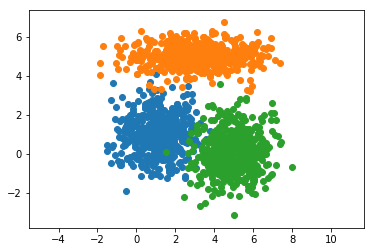

In [4]:
#CodeRead. Do not touch this cell.

mu1=np.array([[1.,1]])
mu2=np.array([[3.,5.]])
mu3=np.array([[5.,0.]])

Sigma1=np.array([[1.,0.],[0.,1.]])
Sigma2=np.array([[3.,0.],[0.,0.3]])
Sigma3=np.array([[1.,0.],[0.,1.]])

A1=np.linalg.cholesky(Sigma1)
A2=np.linalg.cholesky(Sigma2)
A3=np.linalg.cholesky(Sigma3)


X1=np.dot(np.random.randn(500,2),A1)+mu1
X2=np.dot(np.random.randn(500,2),A2)+mu2
X3=np.dot(np.random.randn(500,2),A1)+mu3

plt.axis('equal')
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.scatter(X3[:,0],X3[:,1])


X=np.concatenate((X1,X2,X3),axis=0)


np.random.shuffle(X)
del mu1
del mu2
del mu3
del Sigma1
del Sigma2
del Sigma3


In [60]:
#CodeWrite
def norm(x,mu,sig,det):
    a = (x-mu)
    m = a.transpose()
    k = np.linalg.inv(sig)
    a = np.matmul(a,k)
    a = np.matmul(a,m)
    a = np.exp(a/(-2))
    a = a/(np.sqrt(2*np.pi*det))
    return a

mu1=X[0]
mu2=X[1]
mu3=X[2]

Sigma1=np.array([[1.,0.],[0.,1.]])
Sigma2=np.array([[1.,0.],[0.,1]])
Sigma3=np.array([[1.,0.],[0.,1.]])

pi1 = 1/3
pi2 = 1/3
pi3 = 1/3

l1 = np.zeros(len(X))
l2 = np.zeros(len(X))
l3 = np.zeros(len(X))

det1 = np.linalg.det(Sigma1)
det2 = np.linalg.det(Sigma2)
det3 = np.linalg.det(Sigma3)


ppi1 = pi1
ppi2 = pi2
ppi3 = pi3

pSigma1 = Sigma1
pSigma2 = Sigma2
pSigma3 = Sigma3

pmu1 = mu1
pmu2 = mu2
pmu3 = mu3

pval = 0
for i in range(len(X)):
    temp = pi1*norm(X[i],mu1,Sigma1,det1) + pi2*norm(X[i],mu2,Sigma2,det2) + pi3*norm(X[i],mu3,Sigma3,det3)
    pval = pval + np.log(temp)


flag = True
ii = 0
while(ii<500 and flag):
    for i in range(len(X)):
        a = norm(X[i],mu1,Sigma1,det1)
        b = norm(X[i],mu2,Sigma2,det2)
        c = norm(X[i],mu3,Sigma3,det3)

        l1[i] = (a*pi1) / (a*pi1+b*pi2+c*pi3)
        l2[i] = (b*pi2) / (a*pi1+b*pi2+c*pi3)
        l3[i] = (c*pi3) / (a*pi1+b*pi2+c*pi3)

    tmu1=np.array([[0,0]])
    tmu2=np.array([[0,0]])
    tmu3=np.array([[0,0]])

    pi1=0
    pi2=0
    pi3=0

    Sigma1=np.zeros((2,2))
    Sigma2=np.zeros((2,2))
    Sigma3=np.zeros((2,2))

    for i in range(len(X)):
        tmu1 = tmu1 + l1[i]*X[i]
        tmu2 = tmu2 + l2[i]*X[i]
        tmu3 = tmu3 + l3[i]*X[i]

        pi1 = pi1 + l1[i]
        pi2 = pi2 + l2[i]
        pi3 = pi3 + l3[i]

        temp = (X[i] - mu1).reshape(1,2)
        temp = temp.transpose()
        temp = np.matmul(temp,(X[i]-mu1).reshape(1,2))
        Sigma1 = Sigma1 + l1[i]*temp

        temp = (X[i] - mu2).reshape(1,2)
        temp = temp.transpose()
        temp = np.matmul(temp,(X[i]-mu2).reshape(1,2))
        Sigma2 = Sigma2 + l2[i]*temp

        temp = (X[i] - mu3).reshape(1,2)
        temp = temp.transpose()
        temp = np.matmul(temp,(X[i]-mu3).reshape(1,2))
        Sigma3 = Sigma3 + l3[i]*temp

    mu1 = tmu1 / pi1
    mu2 = tmu2 / pi2
    mu3 = tmu3 / pi3

    Sigma1 = Sigma1 / pi1
    Sigma2 = Sigma2 / pi2
    Sigma3 = Sigma3 / pi3

    pi1 = pi1 / len(X)
    pi2 = pi2 / len(X)
    pi3 = pi3 / len(X)
    
    ii = ii +1
    
    if ppi1 == pi1 and ppi2 == pi2 and ppi3 == pi3 and pSigma1 == Sigma1 and pSigma2 == Sigma2 and pSigma3 == Sigma3 and pmu1 == mu1 and pmu2 == mu2 and pmu1 == mu1:
        flag = False
        
    ppi1 = pi1
    ppi2 = pi2
    ppi3 = pi3

    pSigma1 = Sigma1
    pSigma2 = Sigma2
    pSigma3 = Sigma3

    pmu1 = mu1
    pmu2 = mu2
    pmu3 = mu3
    
    #likelihood calculation
    
    det1 = np.linalg.det(Sigma1)
    det2 = np.linalg.det(Sigma2)
    det3 = np.linalg.det(Sigma3)

    l1 = np.zeros(len(X))
    l2 = np.zeros(len(X))
    l3 = np.zeros(len(X))
    
    val = 0
    for i in range(len(X)):
        temp = pi1*norm(X[i],mu1,Sigma1,det1) + pi2*norm(X[i],mu2,Sigma2,det2) + pi3*norm(X[i],mu3,Sigma3,det3)
        val = val + np.log(temp)
    
    if val == pval:
        flag = False
        
    pval = val
    
print(ii)
print(pi1,pi2,pi3)
print(Sigma1,Sigma2,Sigma3)
print(mu1,mu2,mu3)
    
#convergence


77
0.3335974162390582 0.33143178731881645 0.334970796442125
[[0.99709338 0.02471013]
 [0.02471013 1.00001127]] [[2.96039744 0.05131456]
 [0.05131456 0.2963787 ]] [[0.95461979 0.08226442]
 [0.08226442 1.02714265]]
[[1.09683279 1.01561009]] [[3.0233596  5.00484968]] [[4.97116202 0.05348268]]


TextWrite. Give the estimated $\pi_k$, $\mu_k$ and $\Sigma_k$ for $k\in\{1,2,3\}$

After 77 iterations convergence was achieved

$\pi_1$         0.3335

$\pi_2$         0.3314

$\pi_3$         0.3349

$\mu_1$         [[0.9970  0.0247]
                 [0.0247  1.0000]]
                 
$\mu_2$         [[2.9603  0.0513]
                 [0.0513  0.2963]]
                
$\mu_3$         [[0.9546  0.0822]
                 [0.0822  1.0271]]
                 
$\Sigma_1$      [1.0968 1.0156]

$\Sigma_2$      [3.0233  5.0048]

$\Sigma_3$      [4.9711 0.0534]